# Финальный проект: вариант 2

## Задание 1. A/B–тестирование

In [48]:
import pandas as pd 
import requests 
from urllib.parse import urlencode
import numpy as np
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from statsmodels.regression.linear_model import OLS
from tqdm.auto import tqdm
import pingouin as pg
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

#### Загружаем данные
Таблица с группами **groups.csv** 

In [49]:

# Получаем таблицу с группами
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/hmRKKZTCIr3gnQ' 

# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url_orders = response.json()['href'] 

#загружаем файл в df 
download_response = requests.get(download_url_orders) 
groups_df = pd.read_csv(download_url_orders, sep=';')

In [50]:
groups_df.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


Доп.файл по группам **groups_add.csv** 

In [51]:

# Получаем доп.таблицу с группами
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/mV20xzm72xuyRg' 

# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url_orders = response.json()['href'] 

# загружаем файл в df 
download_response = requests.get(download_url_orders) 
groups_add_df = pd.read_csv(download_url_orders, sep=',')

In [52]:
groups_add_df.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


Таблица с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента **active_studs.csv** 

In [53]:
try:
    # Получаем файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' 

    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url_orders = response.json()['href'] 

    # загружаем файл в df 
    download_response = requests.get(download_url_orders) 
    active_studs_df = pd.read_csv(download_url_orders, sep=',') 
except:
    path_active_studs = 'active_studs_error'
    active_studs_df = pd.read_csv(path_active_studs, sep=',')

In [54]:
active_studs_df.head(5)

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Таблица с информацией об оплатах пользователей в дни проведения эксперимента **checks.csv**

In [55]:
try:
    # Получаем файл с информацией об оплатах пользователей в дни проведения эксперимента.
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    public_key = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 

    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url_orders = response.json()['href'] 

    # загружаем файл в df 
    download_response = requests.get(download_url_orders) 
    checks_df = pd.read_csv(download_url_orders, sep=';') 
except:
    path_checks = 'checks_error'
    checks_df = pd.read_csv(path_checks, sep=';')

In [56]:
checks_df.head(5)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


### Data Validation

1. Проверим на null и тип данных таблицы группы клиентов

In [57]:
groups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [58]:
groups_add_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [59]:
active_studs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [60]:
# Проверяем таблицу с участниками эксперимента на дубликаты
active_studs_df.loc[active_studs_df.duplicated()]

,student_id


In [61]:
checks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [62]:
checks_df.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


### Собираем общий df  
#### 1. Объединим таблицы с группами, и создадим полный справочник клиентов

In [63]:
groups_full_df = groups_df.append(groups_add_df)
groups_full_df.shape

/tmp/ipykernel_210/1310317998.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups_full_df = groups_df.append(groups_add_df)


(74576, 2)

In [64]:
# 1.1. Проверяем на дубликаты
groups_full_df.loc[groups_full_df.duplicated()]

,id,grp


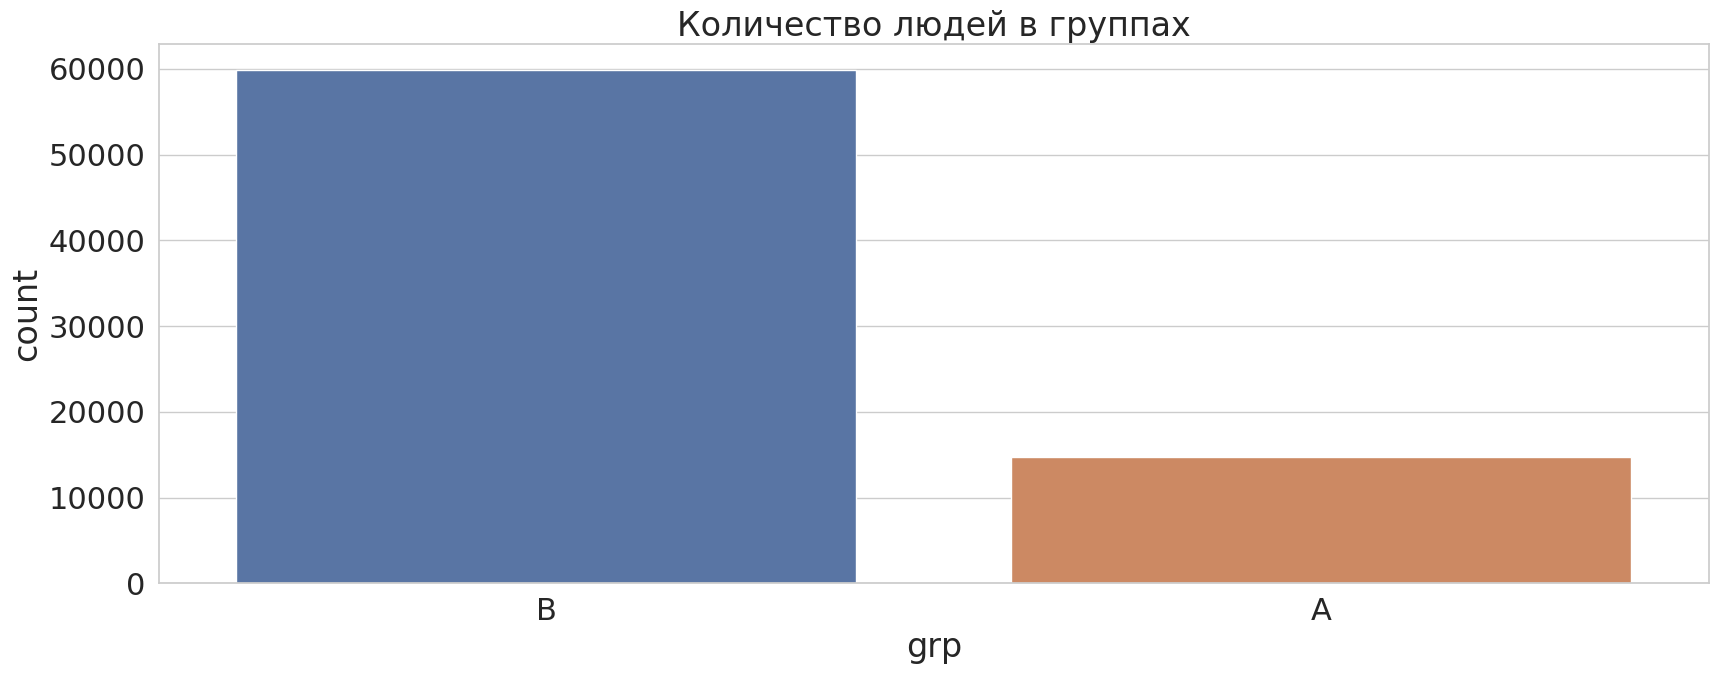

In [65]:
# 1.2. Оценим соотношение людей в группах
count_persosons = sns.countplot(x='grp', data = groups_full_df).set(title='Количество людей в группах')

#### 2. Добавляем столбец info в таблицу с активными пользователями, чтобы при объединении со справочником всех пользоваталей была возможность отфильтровать активных юзеров.

In [66]:
active_studs_df['info'] = 'были на платформе'
active_studs_df.head()

,student_id,info
0,581585,были на платформе
1,5723133,были на платформе
2,3276743,были на платформе
3,4238589,были на платформе
4,4475369,были на платформе


#### 3. Объединяем справочник с клиентами и таблицу с активностью

In [67]:
# Создаем таблицу всех юзеров с группой тестирования и инфой об активности.
all_users = pd.merge(groups_full_df, active_studs_df, how ='left', left_on='id', right_on='student_id').drop('student_id', axis=1)
all_users.head()

,id,grp,info
0,1489,B,NaN
1,1627,A,были на платформе
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN


#### 4. Получаем общий df

In [68]:
# 4.1. К таблице с чеками добавляем юзеров, которые были на платформе в день эксперимента.
big_df = pd.merge(checks_df, all_users, how ='outer',left_on='student_id', right_on='id').drop('student_id', axis=1)
big_df = big_df.query('info=="были на платформе" or rev>0').set_index('id')
big_df['rev'] = big_df['rev'].fillna(0)
# 4.2. Создаем столбец -лейбл, который принимает значение 1, если пользователь совершил покупку и 0 если покупку не совершал.
big_df['converted'] = np.where(big_df.rev>0,1,0)
big_df = big_df.reset_index()
experiment_2_df = big_df
big_df.head()

,id,rev,grp,info,converted
0,1627,990.0,A,были на платформе,1
1,3185,690.0,B,NaN,1
2,25973,690.0,B,NaN,1
3,26280,690.0,B,NaN,1
4,100300,990.0,B,были на платформе,1


### EDA 

#### 1. Подготовим df для анализа чеков по группам

In [69]:
# Переведем чеки в целое число и сгруппируем, чтобы посмотреть сколько вариантов оплат существует для пользователей в разных механиках.
vs_checks_df = big_df.astype({'rev':'int'})
a_checks = vs_checks_df.query('grp=="A" & rev>0').rev.value_counts().to_frame().reset_index().rename(columns={'index':'check','rev':'clients_a'}).sort_values('check')
b_checks = vs_checks_df.query('grp=="B" & rev>0').rev.value_counts().to_frame().reset_index().rename(columns={'index':'check','rev':'clients_b'}).sort_values('check')
# Разбиваем чеки группы А на квантили
a_checks = a_checks.assign(quan_check_a = pd.qcut(a_checks['check'], q=4,duplicates='drop'))
b_checks = b_checks.assign(quan_check_b = pd.qcut(b_checks['check'], q=4,duplicates='drop'))
# Объединяем таблицы, чтобы узнать какие чеки наиболее популярны в группах
a_b_checks = a_checks.merge(b_checks, how='outer',on='check')
# Считаем общее количество клиентов, чтобы высчитать %
a_buyers = a_b_checks.clients_a.sum()
b_buyers = a_b_checks.clients_b.sum()
# считаем % клиентов по группам, по чекам
a_b_checks['clients_a_%'] = np.round(((a_b_checks.clients_a/a_buyers)*100),2)
a_b_checks['clients_b_%'] = np.round(((a_b_checks.clients_b/b_buyers)*100),2)
a_b_checks.head()

,check,clients_a,quan_check_a,clients_b,quan_check_b,clients_a_%,clients_b_%
0,199,7.0,"(198.999, 640.0]",39.0,"(198.999, 716.5]",6.54,8.99
1,290,31.0,"(198.999, 640.0]",63.0,"(198.999, 716.5]",28.97,14.52
2,398,2.0,"(198.999, 640.0]",7.0,"(198.999, 716.5]",1.87,1.61
3,489,2.0,"(198.999, 640.0]",1.0,"(198.999, 716.5]",1.87,0.23
4,580,6.0,"(198.999, 640.0]",9.0,"(198.999, 716.5]",5.61,2.07


#### 2. Узнаем какой % клиентов какие чеки оставляет.

<Figure size 2000x600 with 0 Axes>

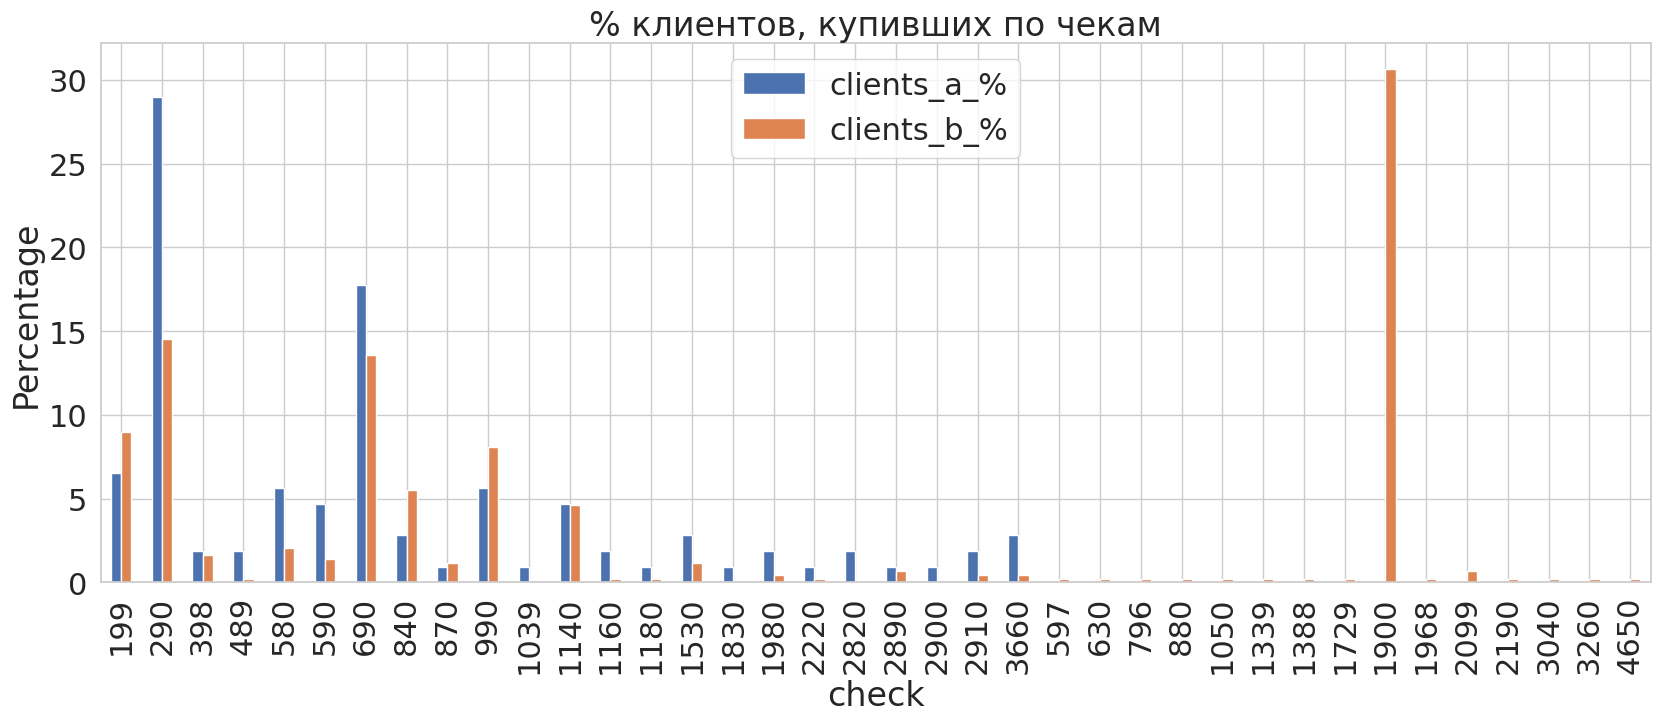

In [70]:
# Оставляем только нужные столбцы для графика
for_bar_pic_df = a_b_checks[['check','clients_a_%','clients_b_%']].set_index('check')
plt.figure(figsize=(20,6))
# Строим график
ab_checks_pic = for_bar_pic_df.plot(kind='bar', stacked=False, color=['#4c72b0', '#dd8452'])
plt.title('% клиентов, купивших по чекам')
plt.xlabel('check')
plt.ylabel('Percentage');

Видно, что в группе 'B' большая часть чеков (более 30%) приходится на 1900 руб. и ощущется смещение в сторону увеличения чека.  также вариантов оплаты больше. 

#### 3. Узнаем количество вариантов оплаты по группам. (чем отличаются механики)

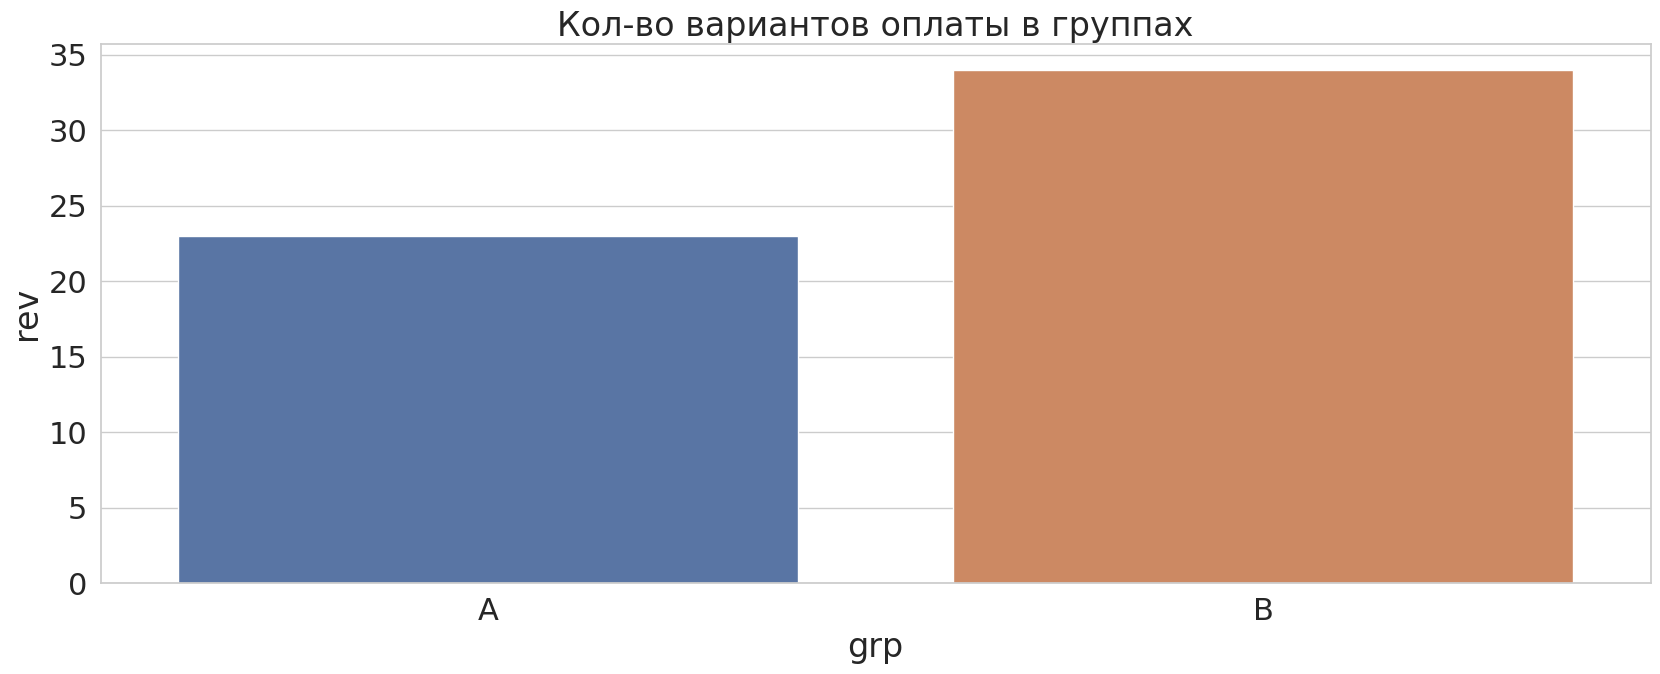

In [71]:
payment_variants = vs_checks_df.query('rev>0 ').groupby('grp').agg({'rev':'nunique'}).reset_index()
sns.barplot(data= payment_variants, x='grp', y='rev').set(title='Кол-во вариантов оплаты в группах');

#### 4. вариантов оплаты больше 20 в обеих группах, поэтому поделим чеки на сегменты для дальнейшего удобства анализа и посчитаем % клиентов по сегментам чеков.

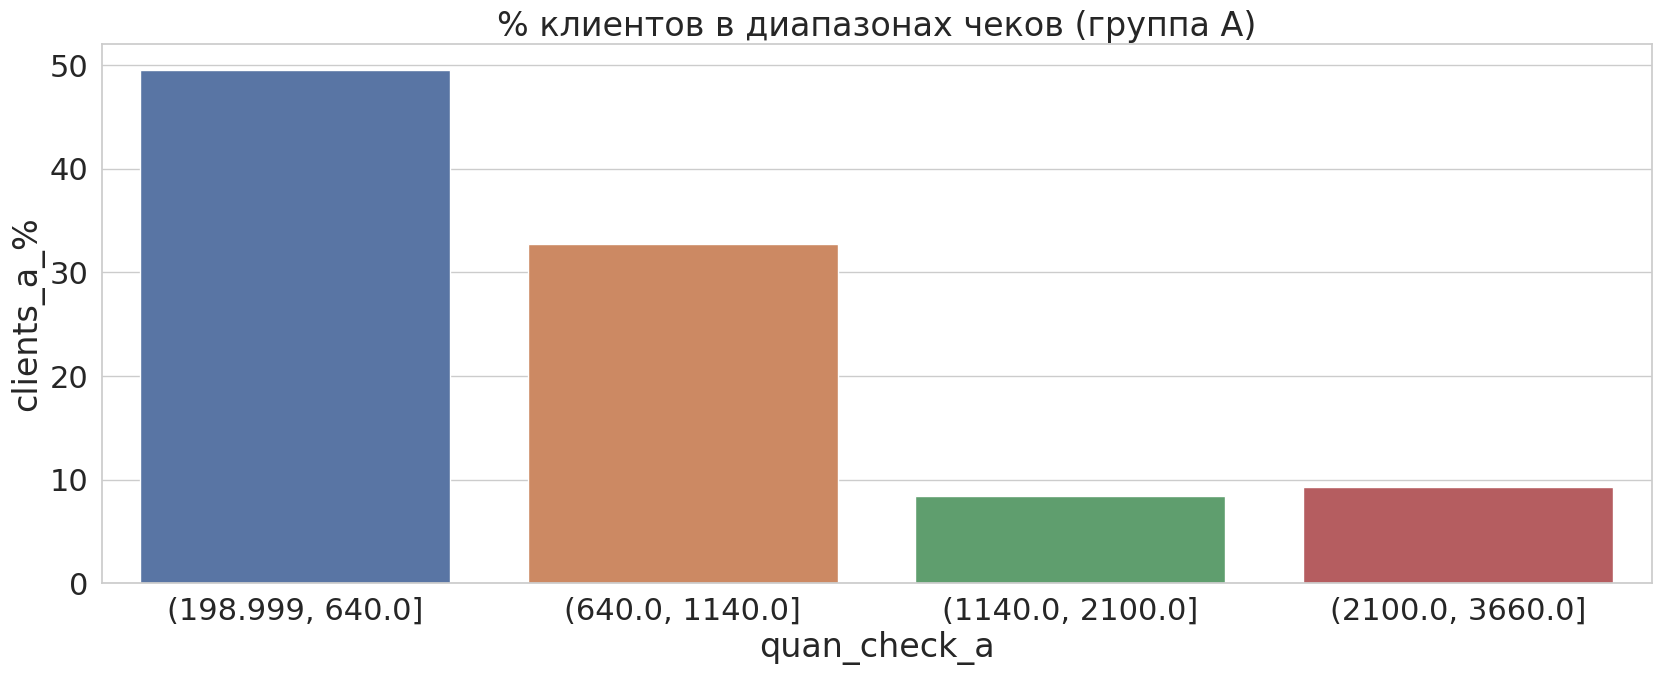

In [72]:
# Разделяем df на группы для barplot-ов 
qan_check_a_bar = a_b_checks.groupby('quan_check_a')['clients_a_%'].sum().to_frame().reset_index()
qan_check_b_bar = a_b_checks.groupby('quan_check_b')['clients_b_%'].sum().to_frame().reset_index()

sns.barplot(data = qan_check_a_bar, x='quan_check_a', y='clients_a_%').set(title='% клиентов в диапазонах чеков (группа А)');

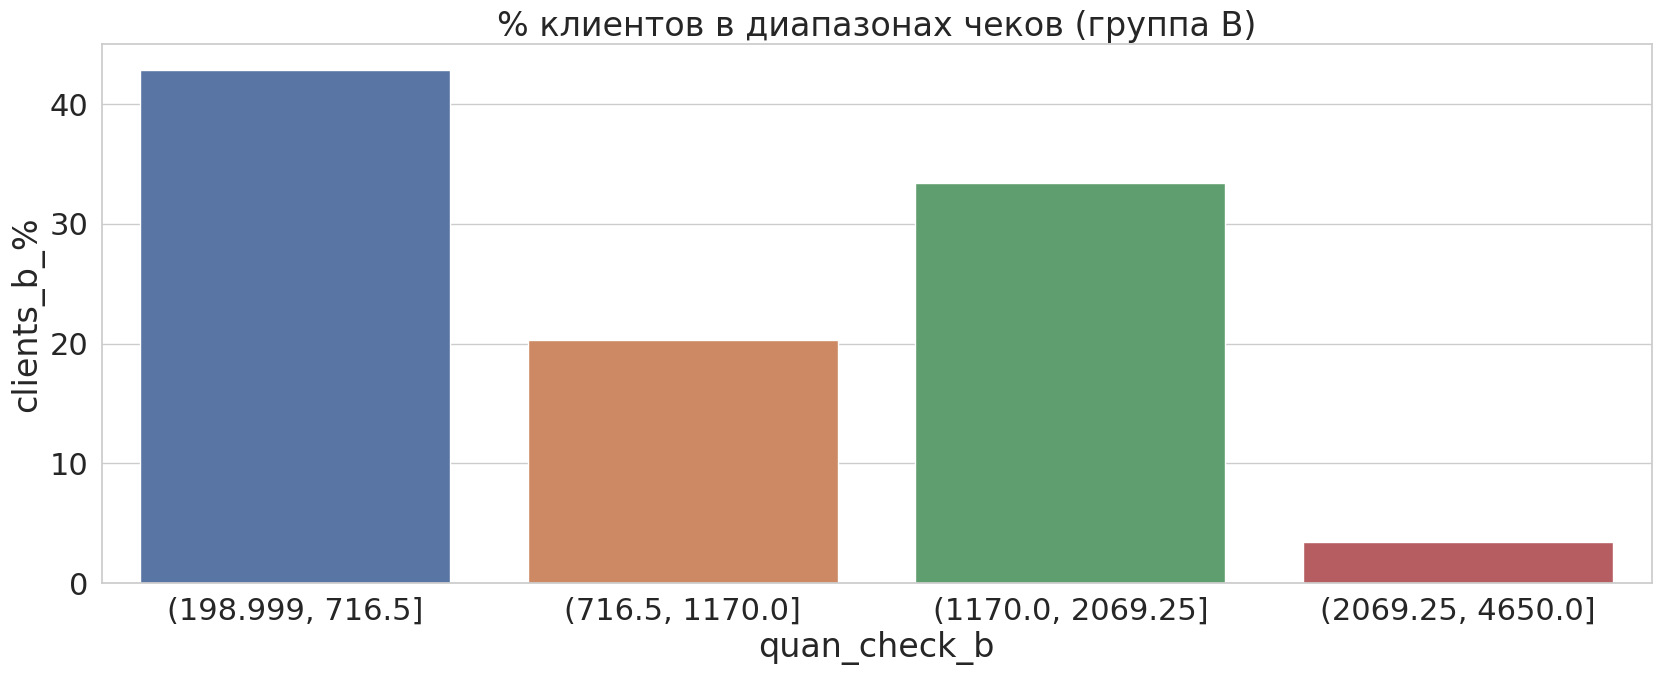

In [73]:
sns.barplot(data = qan_check_b_bar, x='quan_check_b', y='clients_b_%').set(title='% клиентов в диапазонах чеков (группа В)');

В группе "B" больший % клиентов смещен к высоким чекам, чем в группе "A"

#### 5. Построим boxplot, увидеть распредление более наглядно

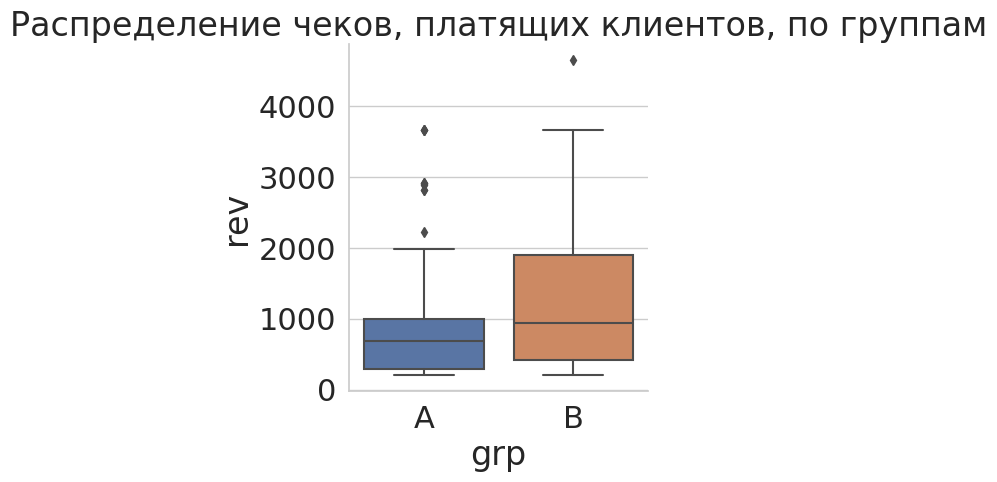

In [74]:
checks_box_pic = sns.catplot( data= big_df[big_df['rev']>0], x="grp", y="rev", kind="box").set(title='Распределение чеков, платящих клиентов, по группам')

Рассмотрим **Median Revenue Per Paying User (MRPPU)** - средний платеж на всех платящих пользователей.

In [75]:
mrppu_by_groups = big_df.query('rev>0').reset_index().groupby(['grp'])\
                .agg(MRPPU = ('rev','median'))
mrppu_by_groups

,MRPPU
grp,
A,690.0
B,935.0


#### 6. Сделаем сводный df, чтобы увидеть основные показатели (cr%, ARPU, ARPPU, MRPPU) по группам

In [76]:

# 3.1. Сгруппируем данные так, чтобы увидеть какова была конверсия для обеих групп.
groups = big_df.reset_index().groupby(['grp'])\
                .agg(\
                    ids = ('id','size'),\
                    revenue = ('rev','sum'),\
                    converted =('converted','sum')\
                    )
# Добавляем столбец с MRPPU
groups = groups.join(mrppu_by_groups)
#  Считаем клиентов, которые не делали покупок
groups['unconverted'] = groups['ids']-groups['converted']
# Считаем % клиентов, которые не делали покупок
groups['part_unconv_%'] = np.round(((groups['unconverted']/groups['ids'])*100),2)
# Считаем CR% 
groups['cr_%'] = round(((groups.converted/groups.ids)*100),2)
groups['revenue'] = np.round((groups.revenue),2)
# # Посчитаем разницу в CR между группами в %
groups['diff%_cr_B-A'] = np.round(((groups.loc['B']['cr_%'] - groups.loc['A']['cr_%'])/groups.loc['A']['cr_%']),2)
# Посчитаем разницу в ARPU между группами абсолют. и в %
groups['ARPU'] = np.round((groups.revenue/groups.ids),2)
groups['diff%_ARPU_B-A'] = np.round((((groups.loc['B']['ARPU'] - groups.loc['A']['ARPU']) / groups.loc['A']['ARPU'])*100),2)
# Посчитаем разницу в ARPPU между группами абсолют. и в %
groups['ARPPU'] = np.round((groups.revenue/groups.converted),2)
# groups['diff_ARPPU_B-A'] = np.round((groups.loc['B']['ARPPU'] - groups.loc['A']['ARPPU']),2)
groups['diff%_ARPPU_B-A'] = np.round((((groups.loc['B']['ARPPU'] - groups.loc['A']['ARPPU']) / groups.loc['A']['ARPPU'])*100),2)
groups['diff%_MRPPU_B-A'] = np.round((((groups.loc['B']['MRPPU'] - groups.loc['A']['MRPPU']) / groups.loc['A']['MRPPU'])*100),2)
# Посчитаем % клиентов в группах
groups['%_clients'] = np.round(((groups['ids']/(groups.loc['A']['ids'] + groups.loc['B']['ids']))*100),2)
groups = groups.reset_index()
summary_deviation = groups[['grp','%_clients','cr_%','ARPU','ARPPU','MRPPU']]
summary_deviation

,grp,%_clients,cr_%,ARPU,ARPPU,MRPPU
0,A,18.46,6.83,58.77,860.71,690.0
1,B,81.54,6.27,69.51,1108.82,935.0


#### 7. Формируем табличку с изменениями по основным метрикам (в %) по группам

In [77]:
summary_deviation_a_b = groups[[ 'diff%_cr_B-A','diff%_ARPU_B-A','diff%_ARPPU_B-A', 'diff%_MRPPU_B-A']]
a_vs_b_deviation = summary_deviation_a_b.stack().to_frame().reset_index().query('level_0==0')\
                    .rename(columns={'level_0':'index', 'level_1':'metric'})
a_vs_b_deviation = a_vs_b_deviation.rename(columns= {a_vs_b_deviation.columns[2]:'B_vs_A_%'})
a_vs_b_deviation['A'] = 100 + a_vs_b_deviation['B_vs_A_%']
a_vs_b_deviation['B'] = 100 - a_vs_b_deviation['B_vs_A_%']
a_vs_b_deviation[['metric','B_vs_A_%']]

,metric,B_vs_A_%
0,diff%_cr_B-A,-0.08
1,diff%_ARPU_B-A,18.27
2,diff%_ARPPU_B-A,28.83
3,diff%_MRPPU_B-A,35.51


Как видно из таблицы изменение в конверсии между группами не значительно, а показатели ARPU (+18%),ARPPU (+28%), и MRPPU (+35%) в пользу тестовой группы

#### 8. Отразим на графике изменения по основным метрикам (в %) по группам

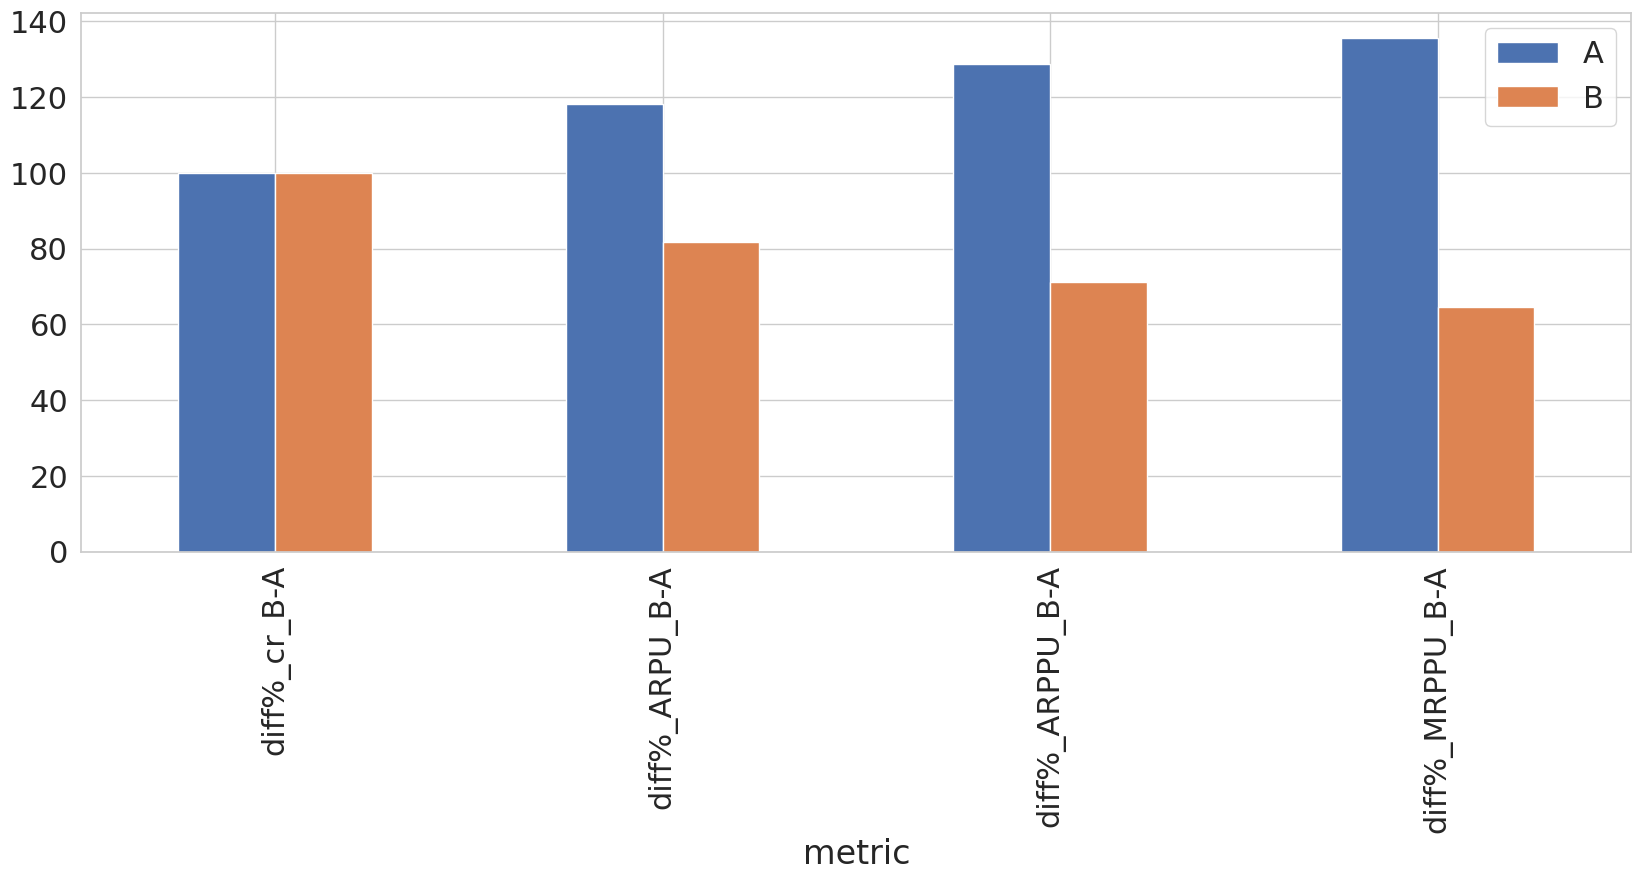

In [78]:
for_stacked_deviation = a_vs_b_deviation[['metric','A','B']].set_index('metric')
for_stacked_deviation.plot(kind='bar', stacked=False, color=['#4c72b0', '#dd8452']);

Осталось проверить являются ли эти изменения статистически значимыми

 ## Проверка гипотез 
###  I Фиксируем гипотезы (CR)
**H0** - новая механика оплаты услуг на сайте НЕ влияет на конверсию в покупку <br>
**H1** - новая механика оплаты услуг на сайте влияет на конверсию в покупку <br> 
<br> Уровень значимости p= 0.05 <br>

#### 1. Готовим таблицу для хи-теста 


In [79]:
# Оставляем только нужные столбцы из df
experiment_2_df = experiment_2_df[['grp','converted']]
# 1) разделяем группы на два отдельных датафрейма
a = experiment_2_df[experiment_2_df['grp'] == 'A']
b = experiment_2_df[experiment_2_df['grp'] == 'B']
# 2) A-purchase, A-nopurchase, B-purchase, B-nopurchase
a_purchase = a.converted.sum()
a_nopurchase = a.converted.size - a.converted.sum()
b_purchase = b.converted.sum()
b_nopurchase = b.converted.size - b.converted.sum()
# 3) Создаем массив
T = np.array([[a_purchase, a_nopurchase], [b_purchase, b_nopurchase]])

In [80]:
# 1.3. Запускаем тест
import scipy
from scipy import stats
print(scipy.stats.chi2_contingency(T,correction=False)[1])

0.41300110944835655


### Вывод по тесту: 
Значение р было рассчитано на уровне 40%. При 5-процентный уровене значимости, мы можем сделать вывод, что p-значение больше альфы и что мы не отвергаем нулевую гипотезу. Проще говоря, нет никакой разницы в конверсиях между старой и новой механикой оплаты.

### II Фиксируем гипотезы (Median Revenue Per Paying User) <br>
**H0** - новая механика оплаты услуг на сайте НЕ влияет на MRPPU <br>
**H1** - новая механика оплаты услуг на сайте влияет на MRPPU <br> 
<br> Уровень значимости p= 0.05 <br>

#### Посчитаем p-value тремя способами: t-тест, U-тест, бутстрап средних

In [81]:
# p-value U-test
from scipy.stats import mannwhitneyu

mann_result = mannwhitneyu(big_df.query('rev>0 & grp=="A"')['rev'], big_df.query('rev>0 & grp=="B"')['rev'])
mann_result

MannwhitneyuResult(statistic=17862.0, pvalue=0.00019316054996380152)

**Результат:** p_value<0.05 Распределения значимо отличаются

In [82]:
# p-value T-test
from scipy import stats

t_test_result = stats.ttest_ind(big_df.query('rev>0 & grp=="A"')['rev'], big_df.query('rev>0 & grp=="B"')['rev'])
t_test_result

Ttest_indResult(statistic=-3.036763731579731, pvalue=0.002507016757204469)

**Результат:** p_value < 0.05 , отклоняем нулевую гипотезу. Различия стат. значимы

In [83]:
# p-value bootstrap

from scipy.stats import norm
import matplotlib.pyplot as plt

plt.style.use('ggplot')
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

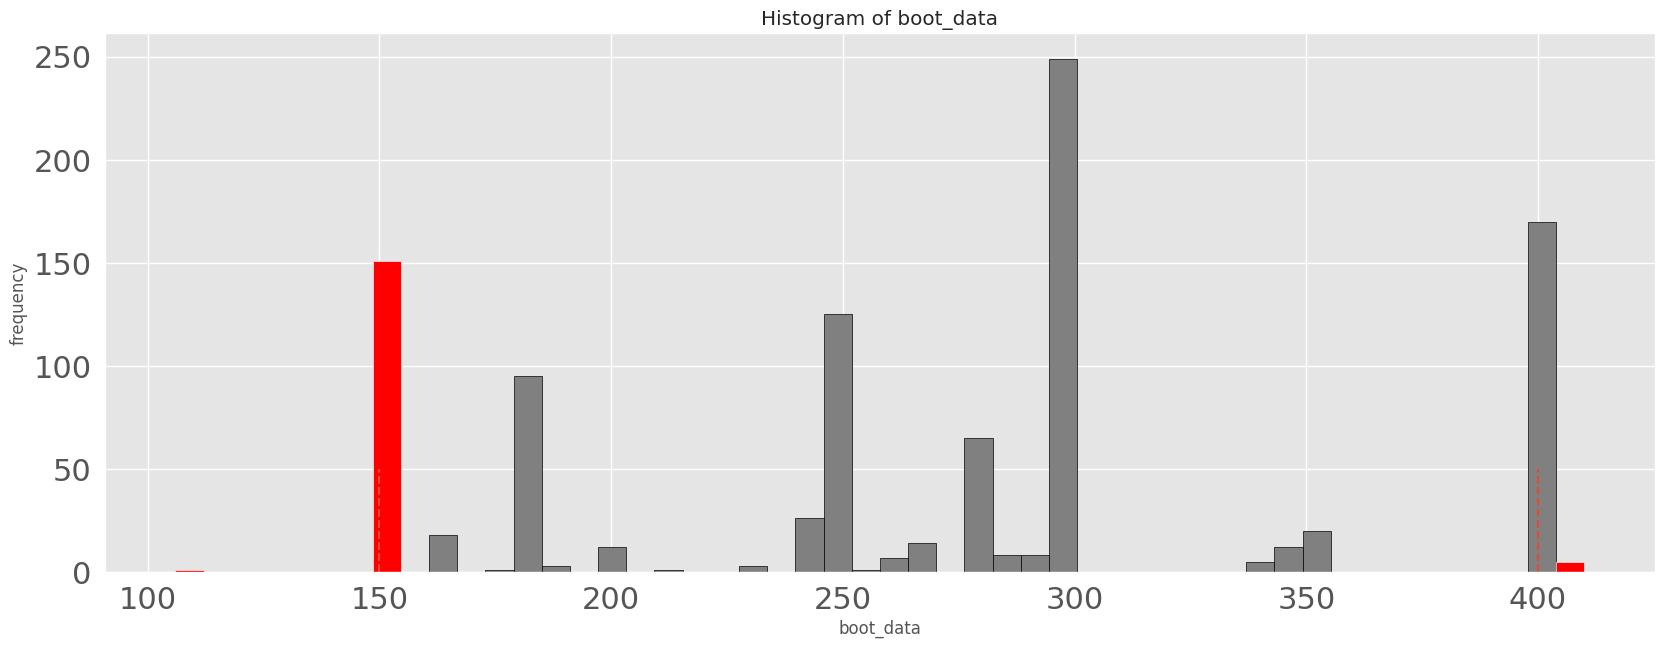

In [84]:
booted_data = get_bootstrap(big_df.query('rev>0 & grp=="B"')['rev'], big_df.query('rev>0 & grp=="A"')['rev']) # в результате хранится разница двух распределений, ДИ и pvalue

In [85]:
# p-value bootstrap
p_value_bootstrap = booted_data["p_value"] # альфа
p_value_bootstrap

0.0009810169512657083

In [86]:
booted_data["quants"]

,0
0.025,150.0
0.975,400.0


**Результат:** p_value < 0.05 , отклоняем нулевую гипотезу. Различия в медианах стат. значимы. Доверительный интервал не пересекает 0 это означает, что нулевое различие не согласуется в полученными нами данными. А это прямое свидетельство в пользу того, что различие между медианами ненулевое. Таким образом разница в средних между группами находится в диапазоне (150 - 400)

#### 1. Проверим данные на соответствия требованиям применения t-testа:
##### 1.1. требование к нормальности данных обеих групп при применении t-теста.

Построим графики распределния

/tmp/ipykernel_210/616908552.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_df.query('rev>0 & grp=="A"')['rev'])
/tmp/ipykernel_210/616908552.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_df.query('rev>0 & grp=="B"')['rev']);


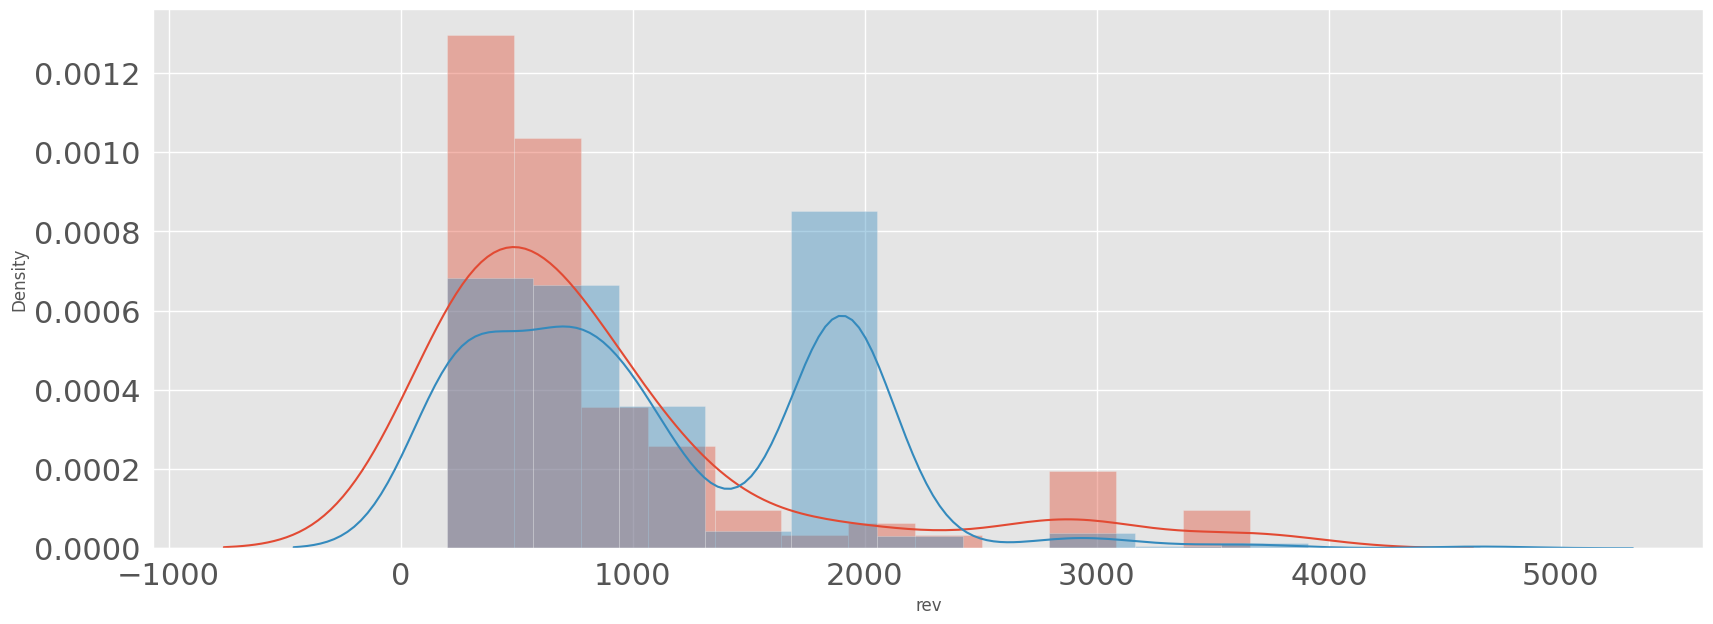

In [87]:
sns.distplot(big_df.query('rev>0 & grp=="A"')['rev'])
sns.distplot(big_df.query('rev>0 & grp=="B"')['rev']);

Ярко выражена ассиметрия, большая часть наблюдений кучкуется в одном месте и есть несколько выделяющихся значений.Фактически это будет влиять на среднее так же, как и выбросы, поэтому при расчете будем брать медиану.

In [88]:


pg.normality(big_df.query('rev>0'), dv='rev', group='grp', method='normaltest')

,W,pval,normal
grp,,,
A,52.218452,4.580439e-12,False
B,33.195875,6.188814e-08,False


#### 1.2. требование гомогенности дисперсий

In [89]:
pg.homoscedasticity(big_df.query('rev>0'), dv='rev', group='grp')

,W,pval,equal_var
levene,4.478901,0.034774,False


**Вывод:** Требования не выполнены, но т.к. выборки в несколько сотен наблюдений, то отклонения от нормальности не так критичны. (нормальность выборочного распределения по ЦПТ и является критичной для t-теста).

In [90]:

b_mean = big_df.query('rev>0 & grp=="B"')['rev'].median()
a_mean = big_df.query('rev>0 & grp=="A"')['rev'].median()

percent = np.round((b_mean-a_mean)/a_mean*100,2)
"Результат между тестом и контролем (в медианах) составил " + str(percent) + "%"

'Результат между тестом и контролем (в медианах) составил 35.51%'

## Вывод: <br> 
Все тесты (u-test,t-test, bootstrap) показали статистически значимые результаты. Исходя из условия задачи (попытка сравнить средние генеральной совокупности) нам  больше подходит t-test т.к. бутстреп создает среднее не из генеральной совокупности, а из выборки.

## Ответы на вопросы (задание 1):

**На какие метрики Вы смотрите в ходе анализа и почему?** <br/>
1) Активные пользователи. Нас интересуют только те кто заходил на платформу и\или оплачивали во время эксперимента. Остальных юзеров из базы мы не учитываем. <br/>
2) CR - конверсия в покупку. Важно понимать конвертит ли новая механика в покупку лучше или хуже. <br/>
3) ARPU, ARPPU - помогает оценить лояльность клиентов, измерить ценность внесенных изменений в продукт. <br/>
4) MRPPU - в эксперименте учавствует вся клиентская база, данные не кластеризованы, поэтому для описания центральной тенденции лучше использоваать медиану. <br/>
**Имеются ли различия в показателях и с чем они могут быть связаны?** <br/>
Разница в CR% между группами незначительна,составляет 0,56 и связана с естественной флуктуацией. 
Различия в ARPU,ARPPU, MRPPU k значительны механики оплаты отличаются между собой количеством тарифов и в новой механике смещение идет в строну увеличение чека. Следовательно, новая механика может сильно повлиять на эти показатели.<br/>
**Являются ли эти различия статистически значимыми?** <br/>
CR - как показали результаты теста хи-квадрат, различия не являются стат.значимыми <br/>
MRPPU - во всех трех тестах различия стат.значимы. Из условия задачи ориентируемся на t-test <br/>
**Стоит ли запускать новую механику на всех пользователей?** <br/>
Стоит, различия в CR не являются стат.значимыми и даже если мы допустили ошибку первого рода, все равно изменение слишком незначительно (-0.08 п.п.). При этом различия между тестом и контролем в медианных чеках составил 35,5%.

## Задание 2. SQL

In [91]:
# Настройка подвлючения к clickhouse
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

### 2.1 Очень усердные ученики.

In [92]:
q = '''
SELECT
    uniqExact(st_id) AS hardworking
FROM    
    (
    SELECT
        st_id,
        date_local,
        SUM(correct) AS score
    FROM    
        (
        SELECT 
            st_id,
            correct,
            toStartOfMonth((timest)) AS date_local
        FROM 
            default.peas
        )
    GROUP BY st_id,date_local
    )
HAVING score>=20 
    '''

In [93]:
q_count_good_st = ph.read_clickhouse(query=q,connection=connection_default)

#### Ответ 2.1.:

In [94]:
q_count_good_st

,hardworking
0,136


### 2.2 Оптимизация воронки

In [95]:
q_task_2_test = '''
SELECT
    grp,
    arpu,
    arpau,
    cr,
    cr_active,
    cr_math
FROM
    (
    SELECT
        main_table.grp,
        dim_users.all_users,
        main_table.users,
        main_table.money,
        main_table.money_AU,
        main_table.active_users,
        main_table.active_math_users,
        main_table.buyers,
        main_table.math_buyer,
        main_table.active_paying_user,
        divide(buyers,all_users)*100 AS cr,
        divide(active_paying_user,active_users)*100 AS cr_active,
        divide(math_buyer,active_math_users)*100 AS cr_math,
        divide(money,all_users) AS arpu,
        divide(money_AU,active_users) AS arpau
    FROM
        (
        SELECT
            grp,
            uniqExact(st_id) AS users,
            SUM(money) AS money,
            SUM(active_math_true) AS active_math_users,
            SUM(active_user) AS active_users,
            SUM(cr) AS buyers,
            SUM(math_purchase) AS buyers_math,
            SUM(money_active_user) AS money_AU,
            SUM(math_buyer) AS math_buyer,
            SUM(active_paying_user) AS active_paying_user
        FROM
            (
            SELECT 
                l.st_id,
                r.test_grp AS grp,
                l.score_total,
                l.active_math_true,
                l.active_user,
                l.cr,
                l.money,
                l.math_purchase,
                CASE WHEN active_user = 1 THEN money ELSE 0 END AS money_active_user,
                CASE WHEN active_math_true = 1 AND math_purchase = 1 THEN 1 ELSE 0 END AS math_buyer,
                CASE WHEN active_user = 1 AND money>0 THEN 1 ELSE 0 END AS active_paying_user
            FROM
                (
                    SELECT
                        CASE WHEN empty(scoring_table.st_id) THEN sales_table.st_id ELSE scoring_table.st_id END AS st_id,
                        scoring_table.score_total AS score_total,
                        scoring_table.active_math_true AS active_math_true,
                        scoring_table.active_user AS active_user,
                        sales_table.cr AS cr,
                        sales_table.money AS money,
                        sales_table.math_purchase AS math_purchase
                    FROM    
                        (
                        SELECT 
                        st_id,
                        SUM(score) AS score_total,
                        MAX(active_math_true) AS active_math_true,
                        CASE WHEN score_total>10 THEN 1 ELSE 0 END AS active_user
                        FROM
                            (
                            SELECT
                                st_id,
                                subject,
                                score,
                                active_math_true
                            FROM
                                (
                                SELECT 
                                    st_id,
                                    subject,
                                    SUM(correct) AS score,
                                    CASE WHEN subject ='Math' AND score >=2 THEN 1 ELSE 0 END AS active_math_true
                                FROM    
                                    (
                                    SELECT 
                                        st_id,
                                        correct,
                                        subject
                                    FROM default.peas
                                    )
                                GROUP BY st_id,subject
                                )
                            )
                        GROUP BY st_id
                        ) AS scoring_table
                    FULL OUTER JOIN 
                        (
                        SELECT 
                            st_id,
                            SUM(money) AS money,
                            MAX(converted) AS cr,
                            MAX(math_purchase) AS math_purchase
                        FROM 
                            (
                            SELECT
                                st_id,
                                subject,
                                SUM(money) AS money,
                                materialize(1) AS converted,
                                CASE WHEN subject ='Math' AND money> 0 THEN 1 ELSE 0 END AS math_purchase
                            FROM
                                (
                                SELECT 
                                    st_id,
                                    toDate(sale_time) AS date_local,
                                    money,
                                    subject
                                FROM default.final_project_check
                                )
                            GROUP BY st_id, subject
                            )
                        GROUP BY st_id
                        ) AS sales_table 
                    ON scoring_table.st_id = sales_table.st_id 
                ) AS l
        LEFT JOIN 
            (
            SELECT *
            FROM default.studs
            ) AS r 
            ON l.st_id = r.st_id
            )
            GROUP BY grp
        ) AS main_table
    LEFT JOIN 
        (
        SELECT
            test_grp AS grp,
            COUNT(DISTINCT st_id) AS all_users
        FROM
        default.studs
        GROUP BY test_grp
        ) AS dim_users
    ON main_table.grp =  dim_users.grp
    )
    
'''

In [96]:
#С помощью join split удаляем пробелы и переносы строки, чтобы уменьшить длину запроса
result_task_2_test = ph.read_clickhouse(query=" ".join(q_task_2_test.split()),connection=connection_default)


#### Ответ 2.2.:

In [97]:
result_task_2_test

,grp,arpu,arpau,cr,cr_active,cr_math
0,control,4540.983607,10393.700787,4.918033,11.023622,6.122449
1,pilot,11508.474576,29739.583333,10.847458,26.041667,9.523810


## Задание 3.

#### Задача 3.1. Решение

In [98]:
def get_groups_add():
        try:
            # Получаем доп.таблицу с группами
            # используем api 
            base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
            public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' 
            # получаем url 
            final_url = base_url + urlencode(dict(public_key=public_key)) 
            response = requests.get(final_url) 
            download_url_orders = response.json()['href'] 
            # загружаем файл в df 
            download_response = requests.get(download_url_orders) 
            groups_add_task3 = pd.read_csv(download_url_orders, sep=',')
        except:
            path = 'file_groups_add_error.csv'
            groups_add_task3 = pd.read_csv(path, sep=',')
        groups_full = pd.DataFrame( np.concatenate( (groups_df.values, groups_add_task3.values), axis=0 ) )
        groups_full.columns = [ 'id', 'grp']
        groups_full.drop_duplicates()
        # Создаем таблицу всех юзеров с группой тестирования и инфой об активности.
        all_users = pd.merge(groups_full, active_studs_df, how ='left', left_on='id', right_on='student_id').drop('student_id', axis=1)
        big_df = pd.merge(checks_df, all_users, how ='outer',left_on='student_id', right_on='id').drop('student_id', axis=1)
        big_df = big_df.query('info=="были на платформе" or rev>0').set_index('id')
        big_df['rev'] = big_df['rev'].fillna(0)
        # Создаем столбец -лейбл, который принимает значение 1, если пользователь совершил покупку и 0 если покупку не совершал.
        big_df['converted'] = np.where(big_df.rev>0,1,0)
        groups = big_df.reset_index().groupby(['grp'])\
                .agg(\
                    ids = ('id','size'),\
                    revenue = ('rev','sum'),\
                    converted =('converted','sum')\
                    )
        # Добавляем столбец с MRPPU
        groups = pd.concat([groups, mrppu_by_groups], axis=1)
        #  Считаем клиентов, которые не делали покупок
        groups['unconverted'] = groups['ids']-groups['converted']
        # Считаем % клиентов, которые не делали покупок
        groups['part_unconv_%'] = np.round(((groups['unconverted']/groups['ids'])*100),2)
        # Считаем CR% 
        groups['cr_%'] = round(((groups.converted/groups.ids)*100),2)
        groups['revenue'] = np.round((groups.revenue),2)
        # # Посчитаем разницу в CR между группами в %
        groups['diff%_cr_B-A'] = np.round(((groups.loc['B']['cr_%'] - groups.loc['A']['cr_%'])/groups.loc['A']['cr_%']),2)
        # Посчитаем разницу в ARPU между группами абсолют. и в %
        groups['ARPU'] = np.round((groups.revenue/groups.ids),2)
        groups['diff%_ARPU_B-A'] = np.round((((groups.loc['B']['ARPU'] - groups.loc['A']['ARPU']) / groups.loc['A']['ARPU'])*100),2)
        # Посчитаем разницу в ARPPU между группами абсолют. и в %
        groups['ARPPU'] = np.round((groups.revenue/groups.converted),2)
        # groups['diff_ARPPU_B-A'] = np.round((groups.loc['B']['ARPPU'] - groups.loc['A']['ARPPU']),2)
        groups['diff%_ARPPU_B-A'] = np.round((((groups.loc['B']['ARPPU'] - groups.loc['A']['ARPPU']) / groups.loc['A']['ARPPU'])*100),2)
        groups['diff%_MRPPU_B-A'] = np.round((((groups.loc['B']['MRPPU'] - groups.loc['A']['MRPPU']) / groups.loc['A']['MRPPU'])*100),2)
        # Посчитаем % клиентов в группах
        groups['%_clients'] = np.round(((groups['ids']/(groups.loc['A']['ids'] + groups.loc['B']['ids']))*100),2)
        f_one_result = groups.reset_index()[
            ['grp','%_clients','cr_%','ARPU','ARPPU','MRPPU','diff%_cr_B-A','diff%_ARPU_B-A','diff%_ARPPU_B-A','diff%_MRPPU_B-A']]
        return f_one_result

#### Задача 3.1. Результат

In [99]:
get_groups_add()

,grp,%_clients,cr_%,ARPU,ARPPU,MRPPU,diff%_cr_B-A,diff%_ARPU_B-A,diff%_ARPPU_B-A,diff%_MRPPU_B-A
0,A,18.46,6.83,58.77,860.71,690.0,-0.08,18.27,28.83,35.51
1,B,81.54,6.27,69.51,1108.82,935.0,-0.08,18.27,28.83,35.51


#### Задача 3.2. Решение

In [100]:
f_one_result = get_groups_add()

In [101]:
def visuals_total(param):
    param = param[[ 'diff%_cr_B-A','diff%_ARPU_B-A','diff%_ARPPU_B-A','diff%_MRPPU_B-A']]
    param = param.stack().to_frame().reset_index().query('level_0==0')\
                    .rename(columns={'level_0':'index', 'level_1':'metric'})
    param = param.rename(columns= {param.columns[2]:'B_vs_A_%'})
    param['A'] = 100 + a_vs_b_deviation['B_vs_A_%']
    param['B'] = 100 - a_vs_b_deviation['B_vs_A_%']
    param = param[['metric','A','B']].set_index('metric').plot(kind='bar', stacked=False, color=['#4c72b0', '#dd8452']);
    return param

#### Задача 3.2. Результат

<Axes: xlabel='metric'>

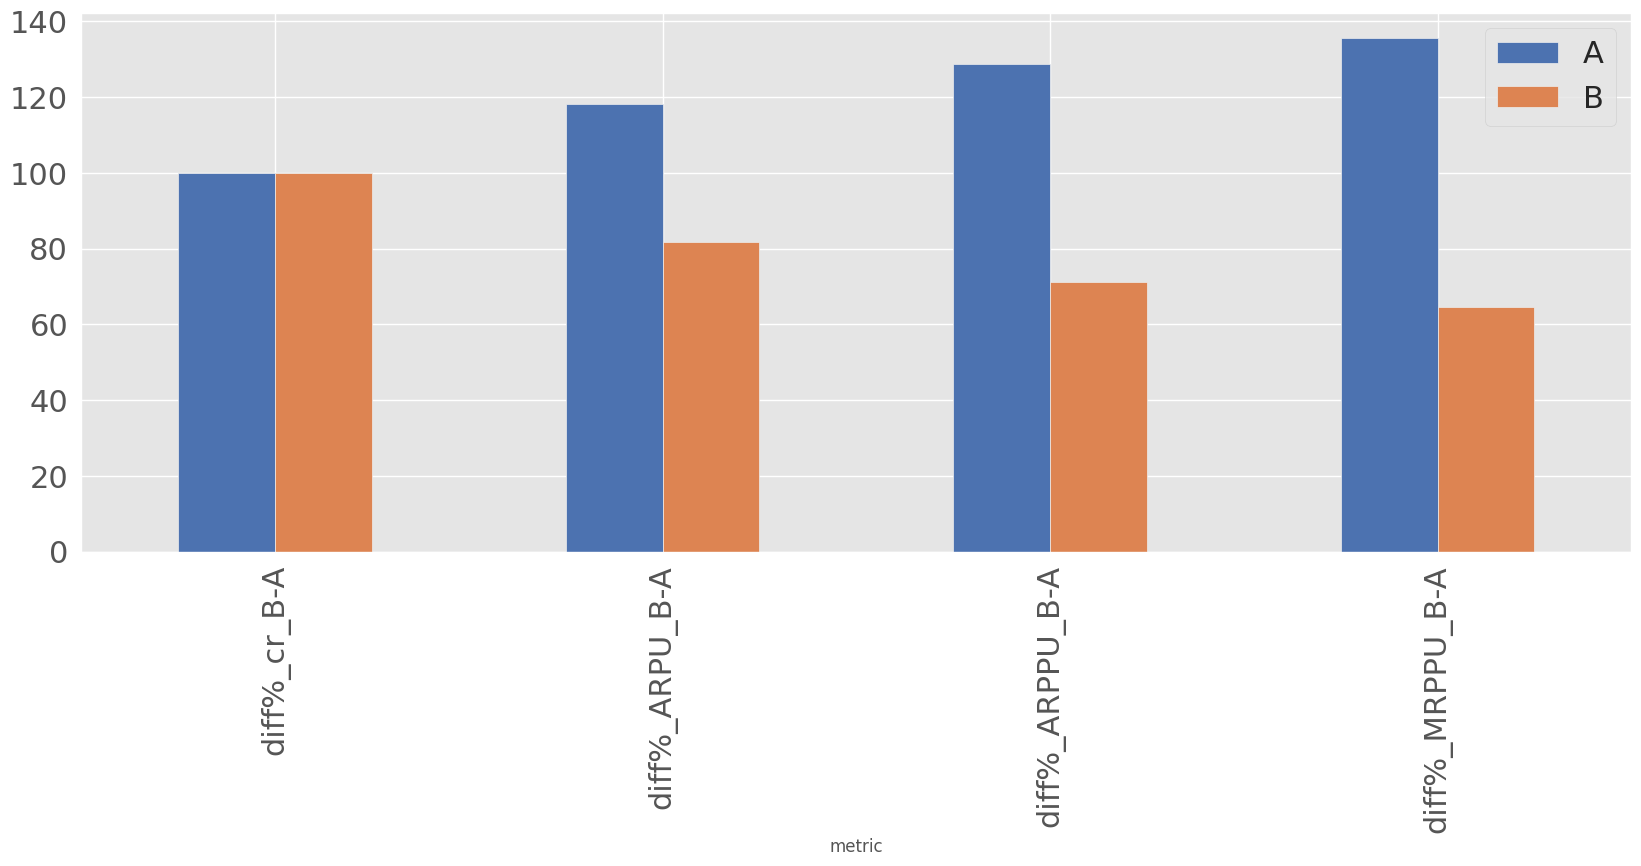

In [102]:
visuals_total(f_one_result)